In [1]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [2]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors

def torch_data_from_noisy_generators(dataset_generators):
    tensors = list()
    for dataset_generator in dataset_generators:
        # convert this from arr to tensor after numpy change
        original_arr = dataset_generator.samples
        denoised_arr = dataset_generator.wave
        assert original_arr.shape == denoised_arr.shape, f'{original_arr.shape} != {denoised_arr.shape}'
        original_tensor = torch.from_numpy(original_arr)
        denoised_tensor = torch.from_numpy(denoised_arr)
        tensors.append((original_tensor, denoised_tensor))
            
    original_tensors, denoised_tensors = zip(*tensors)
    original_tensor = torch.cat(original_tensors, dim=0).unsqueeze(axis=1).double()
    denoised_tensor = torch.cat(denoised_tensors, dim=0).double()
    return original_tensor, denoised_tensor
    
class TorchDenoisingDataset(Dataset):
    def __init__(self, input_tensor, output_tensor):
        assert input_tensor.shape[0] == output_tensor.shape[0], f'{input_tensor.shape} != {output_tensor.shape[0]}'
        self._original = input_tensor
        self._denoised = output_tensor
        return
    
    @property
    def shape(self):
        return self._original.shape

    def __len__(self):
        return self._original.shape[0]

    def __getitem__(self, index):
        original = self._original[index]
        denoised = self._denoised[index]
        return original, denoised

In [3]:
large_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5)
small_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.05).t_noise(std=.01, dof=5)
flat_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.005).t_noise(std=.01, dof=5)

dataset_samples = 10_000
dataset_generators = [
    large_wave_gen.sample(dataset_samples),
    small_wave_gen.sample(dataset_samples),
    flat_wave_gen.sample(dataset_samples),
]

In [4]:
original, denoised = torch_data_from_noisy_generators(dataset_generators)
train_original, test_original, train_denoised, test_denoised = torch_train_test_split(original, denoised, split=.8)

train_dataset = TorchDenoisingDataset(train_original, train_denoised)
test_dataset = TorchDenoisingDataset(test_original, test_denoised)

In [5]:
class SineDAE(nn.Module):
    def __init__(
        self, 
        input_size, 
        out_channels=16, 
        kernel_size=2, 
        stride=4, 
        pool_kernel=4, 
        drop=.4, 
        alpha=.2,
    ):
        super(SineDAE, self).__init__()
        conv1_shape = (input_size - kernel_size) // stride + 1
        pool_shape = (conv1_shape - pool_kernel) // pool_kernel + 1
        conv1t_shape = (out_channels - 1) * stride + (kernel_size - 1) + 1
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
            nn.LeakyReLU(negative_slope=alpha),
            nn.MaxPool1d(kernel_size=pool_kernel),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(pool_shape, 1, kernel_size, stride=stride),
            nn.LeakyReLU(negative_slope=alpha),
            nn.Linear(conv1t_shape, input_size + 1),
        )
    
        print(self.decoder[0])
    
        return
        
    def forward(self, x):
        x_enc = self.encoder(x)
#         display(x_enc.shape)
        x_enc = x_enc.transpose(1, 2)
#         display(x_enc.shape)
        x_dec = self.decoder(x_enc).squeeze(dim=1)
        return x_dec

In [6]:
def train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        p = print_ & True
        for (train_original, train_denoised), (test_original, test_denoised) in zip(train_dataloader, test_dataloader):
            optimizer.zero_grad()
            train_output = model(train_original)
            
            assert train_output.shape == train_denoised.shape, f'{train_output.shape} != {train_denoised.shape}'
            train_loss = criterion(train_output, train_denoised)       
            train_loss.backward()
            optimizer.step()

            test_output = model(test_original)
            test_loss = criterion(test_output, test_denoised)

            if p and not epoch % 10:
                print('Train Loss', train_loss.item())
                print('Test Loss', test_loss.item())
                p = False
                
        if test_full:
            train_original, train_denoised = train_dataset[:]
            test_original, test_denoised = test_dataset[:]
            train_output = model(train_original)
            train_loss = criterion(train_output, train_denoised)
            test_output = model(test_original)
            test_loss = criterion(test_output, test_denoised)
            if early_stop_patience:
                if test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[:-early_stop_patience]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((train_loss.item(), test_loss.item()))
    return model, items

def plot_loss(items, title='', step=1):
    plt.figure(figsize=(16,8))
    train_loss, test_loss = zip(*items)
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[3], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [7]:
out_channelss = [1,2,4]
kernel_sizes = [4,8,6,32]
strides = [4,16,32,64,128]
pool_kernels = [16,32,128,192,256]

total_i = np.prod((len(out_channelss), len(kernel_sizes), len(strides), len(pool_kernels)))

columns = ['out_channels','kernel_size','stride','pool_kernel','train_loss','test_loss']
rows = list()
n_epochs = 30
batch_size = 128
for i, (out_channels, kernel_size, stride, pool_kernel) in enumerate(itertools.product(out_channelss, kernel_sizes, strides, pool_kernels)):
    if stride is None:
        stride = kernel_size
    if stride > kernel_size or stride > pool_kernel:
        continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(out_channels, kernel_size, stride, pool_kernel, sep='|')
    
    model = SineDAE(
        train_dataset.shape[2] - 1,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        pool_kernel=pool_kernel,
    ).double()
    
    try:
        model, items = train(
            model, 
            train_dataset, 
            test_dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        )
    except RuntimeError as re:
        warnings.warn(str(re))
        continue
        
    if not len(items):
        print('Missing loss')
        continue
    train_loss, test_loss = zip(*items)
    train_loss = np.mean(train_loss[2:])
    test_loss = np.mean(test_loss[2:])
    
    rows.append((out_channels, kernel_size, stride, pool_kernel, train_loss, test_loss))

Input Set 1 out of 300
1|4|4|16
ConvTranspose1d(15, 1, kernel_size=(4,), stride=(4,))
Input Set 2 out of 300
1|4|4|32
ConvTranspose1d(7, 1, kernel_size=(4,), stride=(4,))


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Input Set 3 out of 300
1|4|4|128
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 4 out of 300
1|4|4|192
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 5 out of 300
1|4|4|256
ConvTranspose1d(0, 1, kernel_size=(4,), stride=(4,))


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x250). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 26 out of 300
1|8|4|16
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(4,))
Input Set 27 out of 300
1|8|4|32
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(4,))
Input Set 28 out of 300
1|8|4|128
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 29 out of 300
1|8|4|192
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 30 out of 300
1|8|4|256
ConvTranspose1d(0, 1, kernel_size=(8,), stride=(4,))
Input Set 51 out of 300
1|6|4|16
ConvTranspose1d(15, 1, kernel_size=(6,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x249). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 52 out of 300
1|6|4|32
ConvTranspose1d(7, 1, kernel_size=(6,), stride=(4,))
Missing loss
Input Set 53 out of 300
1|6|4|128
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Input Set 54 out of 300
1|6|4|192
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Input Set 55 out of 300
1|6|4|256
ConvTranspose1d(0, 1, kernel_size=(6,), stride=(4,))
Input Set 76 out of 300
1|32|4|16
ConvTranspose1d(15, 1, kernel_size=(32,), stride=(4,))
Missing loss
Input Set 77 out of 300
1|32|4|32
ConvTranspose1d(7, 1, kernel_size=(32,), stride=(4,))
Input Set 78 out of 300
1|32|4|128
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 79 out of 300
1|32|4|192
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 80 out of 300
1|32|4|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(4,))
Input Set 81 out of 300
1|32|16|16
ConvTranspose1d(3, 1, kernel_size=(32,), stride=(16,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x243). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 82 out of 300
1|32|16|32
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(16,))
Input Set 83 out of 300
1|32|16|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 84 out of 300
1|32|16|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 85 out of 300
1|32|16|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 87 out of 300
1|32|32|32
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 88 out of 300
1|32|32|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 89 out of 300
1|32|32|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 90 out of 300
1|32|32|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 101 out of 300
2|4|4|16
ConvTranspose1d(15, 1, kernel_size=(4,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x61). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (1x1x31). Calculated output size: (1x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 102 out of 300
2|4|4|32
ConvTranspose1d(7, 1, kernel_size=(4,), stride=(4,))
Input Set 103 out of 300
2|4|4|128
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 104 out of 300
2|4|4|192
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 105 out of 300
2|4|4|256
ConvTranspose1d(0, 1, kernel_size=(4,), stride=(4,))
Input Set 126 out of 300
2|8|4|16
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x250). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Missing loss
Input Set 127 out of 300
2|8|4|32
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(4,))
Input Set 128 out of 300
2|8|4|128
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 129 out of 300
2|8|4|192
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 130 out of 300
2|8|4|256
ConvTranspose1d(0, 1, kernel_size=(8,), stride=(4,))
Input Set 151 out of 300
2|6|4|16
ConvTranspose1d(15, 1, kernel_size=(6,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x249). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Missing loss
Input Set 152 out of 300
2|6|4|32
ConvTranspose1d(7, 1, kernel_size=(6,), stride=(4,))
Input Set 153 out of 300
2|6|4|128
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Missing loss
Input Set 154 out of 300
2|6|4|192
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Input Set 155 out of 300
2|6|4|256
ConvTranspose1d(0, 1, kernel_size=(6,), stride=(4,))
Input Set 176 out of 300
2|32|4|16
ConvTranspose1d(15, 1, kernel_size=(32,), stride=(4,))
Input Set 177 out of 300
2|32|4|32
ConvTranspose1d(7, 1, kernel_size=(32,), stride=(4,))
Input Set 178 out of 300
2|32|4|128
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 179 out of 300
2|32|4|192
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 180 out of 300
2|32|4|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(4,))
Input Set 181 out of 300
2|32|16|16
ConvTranspose1d(3, 1, kernel_size=(32,), stride=(16,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x243). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Missing loss
Input Set 182 out of 300
2|32|16|32
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(16,))
Input Set 183 out of 300
2|32|16|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 184 out of 300
2|32|16|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 185 out of 300
2|32|16|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 187 out of 300
2|32|32|32
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 188 out of 300
2|32|32|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 189 out of 300
2|32|32|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 190 out of 300
2|32|32|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 201 out of 300
4|4|4|16
ConvTranspose1d(15, 1, kernel_size=(4,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x61). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (2x1x31). Calculated output size: (2x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 202 out of 300
4|4|4|32
ConvTranspose1d(7, 1, kernel_size=(4,), stride=(4,))
Input Set 203 out of 300
4|4|4|128
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 204 out of 300
4|4|4|192
ConvTranspose1d(1, 1, kernel_size=(4,), stride=(4,))
Input Set 205 out of 300
4|4|4|256
ConvTranspose1d(0, 1, kernel_size=(4,), stride=(4,))
Input Set 226 out of 300
4|8|4|16
ConvTranspose1d(15, 1, kernel_size=(8,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x250). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 227 out of 300
4|8|4|32
ConvTranspose1d(7, 1, kernel_size=(8,), stride=(4,))
Missing loss
Input Set 228 out of 300
4|8|4|128
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Missing loss
Input Set 229 out of 300
4|8|4|192
ConvTranspose1d(1, 1, kernel_size=(8,), stride=(4,))
Input Set 230 out of 300
4|8|4|256
ConvTranspose1d(0, 1, kernel_size=(8,), stride=(4,))
Input Set 251 out of 300
4|6|4|16
ConvTranspose1d(15, 1, kernel_size=(6,), stride=(4,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x249). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 252 out of 300
4|6|4|32
ConvTranspose1d(7, 1, kernel_size=(6,), stride=(4,))
Input Set 253 out of 300
4|6|4|128
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Missing loss
Input Set 254 out of 300
4|6|4|192
ConvTranspose1d(1, 1, kernel_size=(6,), stride=(4,))
Input Set 255 out of 300
4|6|4|256
ConvTranspose1d(0, 1, kernel_size=(6,), stride=(4,))
Input Set 276 out of 300
4|32|4|16
ConvTranspose1d(15, 1, kernel_size=(32,), stride=(4,))
Input Set 277 out of 300
4|32|4|32
ConvTranspose1d(7, 1, kernel_size=(32,), stride=(4,))
Input Set 278 out of 300
4|32|4|128
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 279 out of 300
4|32|4|192
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(4,))
Input Set 280 out of 300
4|32|4|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(4,))
Input Set 281 out of 300
4|32|16|16
ConvTranspose1d(3, 1, kernel_size=(32,), stride=(16,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x243). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


Input Set 282 out of 300
4|32|16|32
ConvTranspose1d(1, 1, kernel_size=(32,), stride=(16,))
Input Set 283 out of 300
4|32|16|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 284 out of 300
4|32|16|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 285 out of 300
4|32|16|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(16,))
Input Set 287 out of 300
4|32|32|32
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 288 out of 300
4|32|32|128
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 289 out of 300
4|32|32|192
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))
Input Set 290 out of 300
4|32|32|256
ConvTranspose1d(0, 1, kernel_size=(32,), stride=(32,))


C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x61). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))
C:\Users\Nick\AppData\Local\Temp\ipykernel_14576\2298423687.py:40: UserWarning: Given input size: (4x1x31). Calculated output size: (4x1x0). Output size is too small
  warnings.warn(str(re))


In [8]:
grid_df = pd.DataFrame(rows)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

,out_channels,kernel_size,stride,pool_kernel,train_loss,test_loss
0,1,4,4,16,0.000357,0.000359
1,1,4,4,32,NaN,NaN
2,1,4,4,128,NaN,NaN
3,1,4,4,192,NaN,NaN
4,1,8,4,16,0.000356,0.000356
5,1,8,4,32,0.000169,0.000170
6,1,8,4,128,0.000387,0.000390
7,1,8,4,192,0.000064,0.000065
8,1,6,4,16,NaN,NaN
9,1,6,4,128,NaN,NaN


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


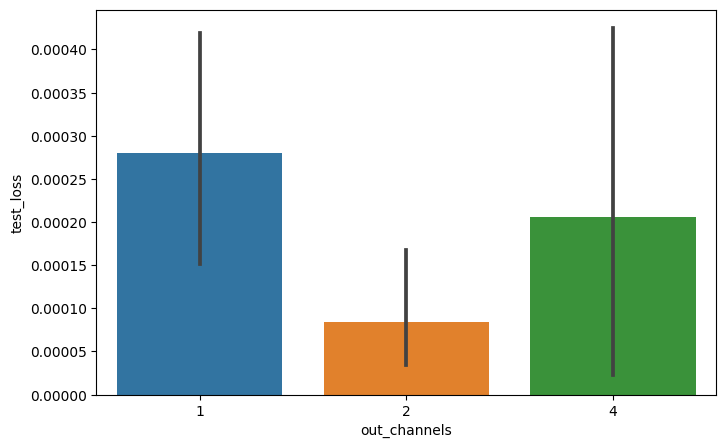

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


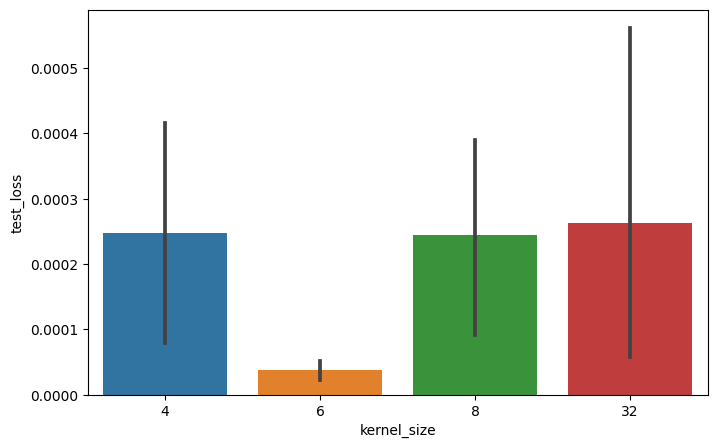

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


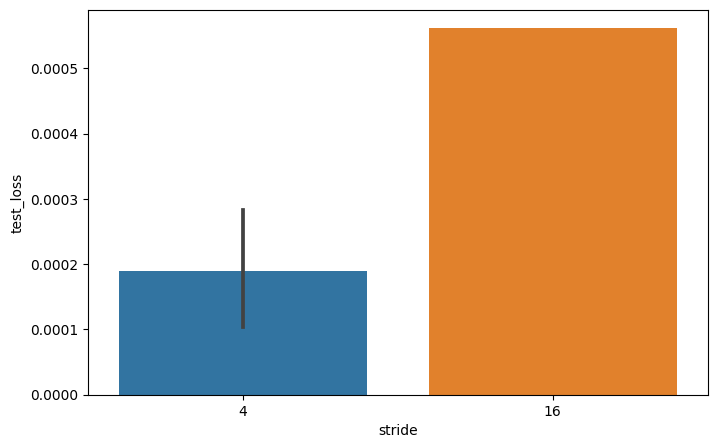

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


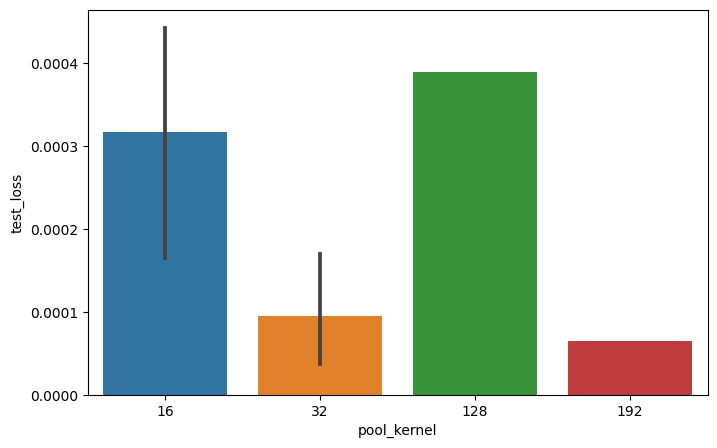

In [9]:
for col in ['out_channels','kernel_size','stride','pool_kernel']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

ConvTranspose1d(7, 1, kernel_size=(6,), stride=(4,))


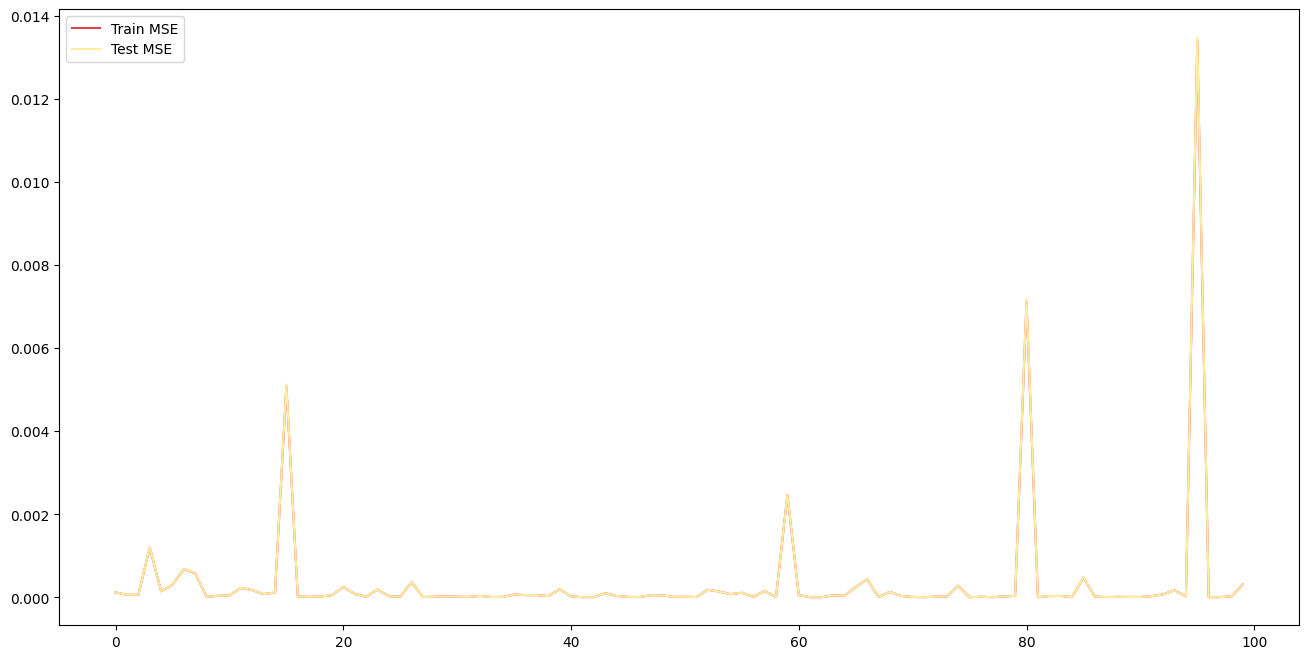

In [10]:
best_out_channels, best_kernel_size, best_stride, best_pool_kernel = grid_df.iloc[grid_df['test_loss'].argmin(),:4].to_numpy(dtype=np.int32)

# display(best_out_channels, best_kernel_size, best_stride, best_pool_kernel)
model = SineDAE(
    train_dataset.shape[2] - 1,
    out_channels=best_out_channels,
    kernel_size=best_kernel_size,
    stride=best_stride,
    pool_kernel=best_pool_kernel,
).double()

model, items = train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=100, 
    test_full=True, 
    early_stop_patience=None,
) 
plot_loss(
    items,
    title=''
)
torch.save(model, 'best_dae_model.pt')

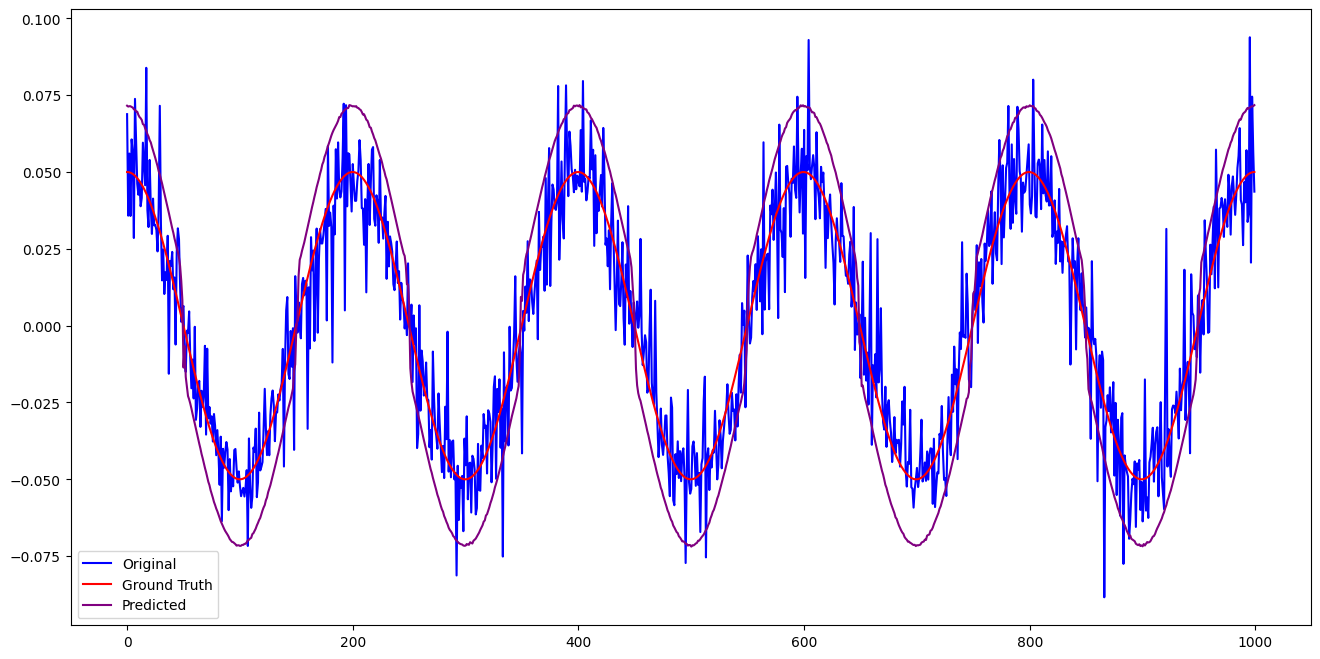

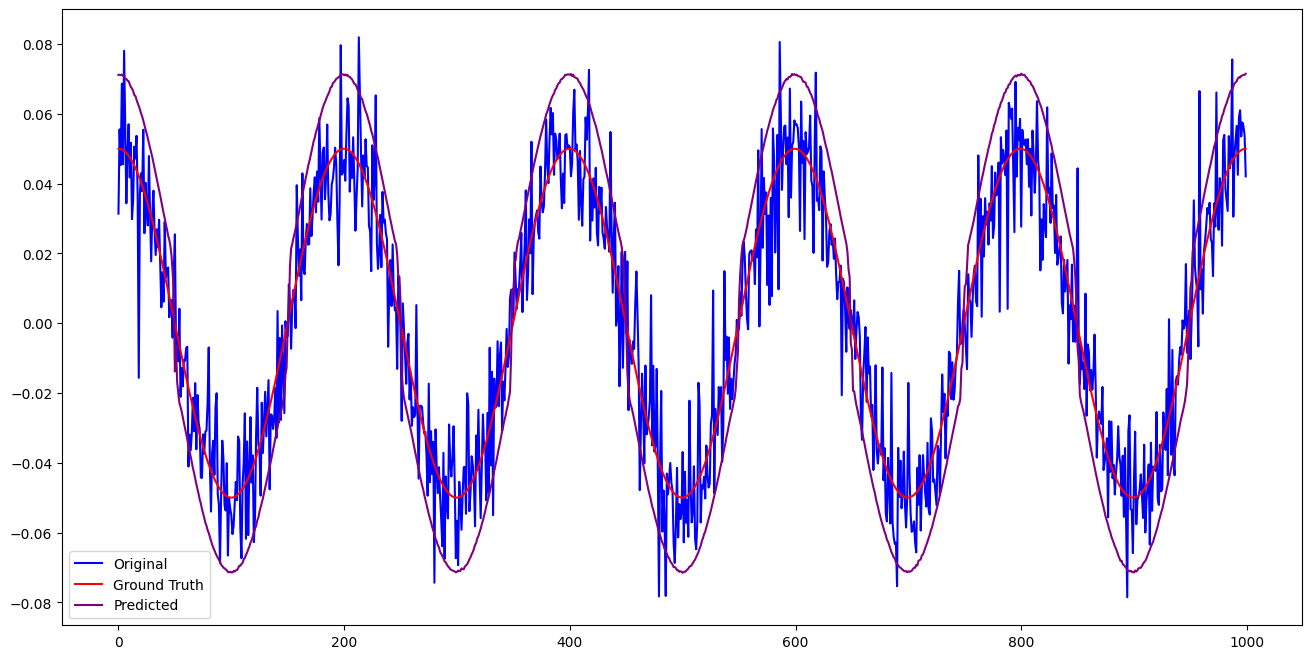

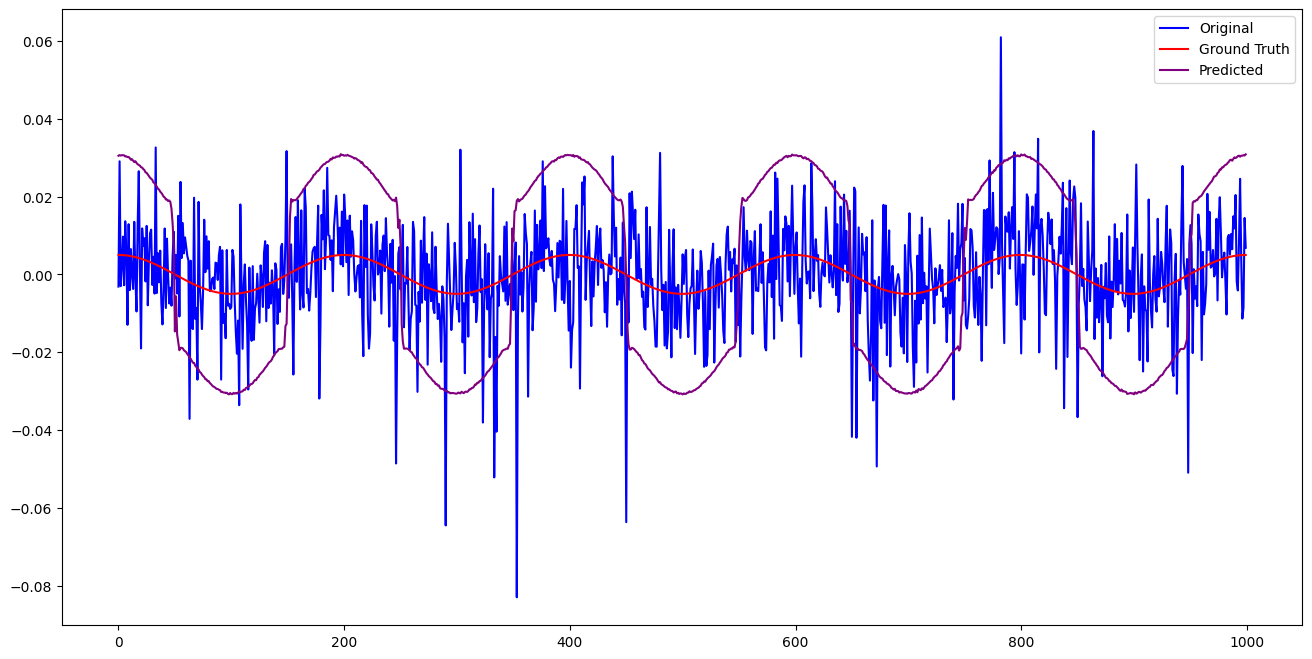

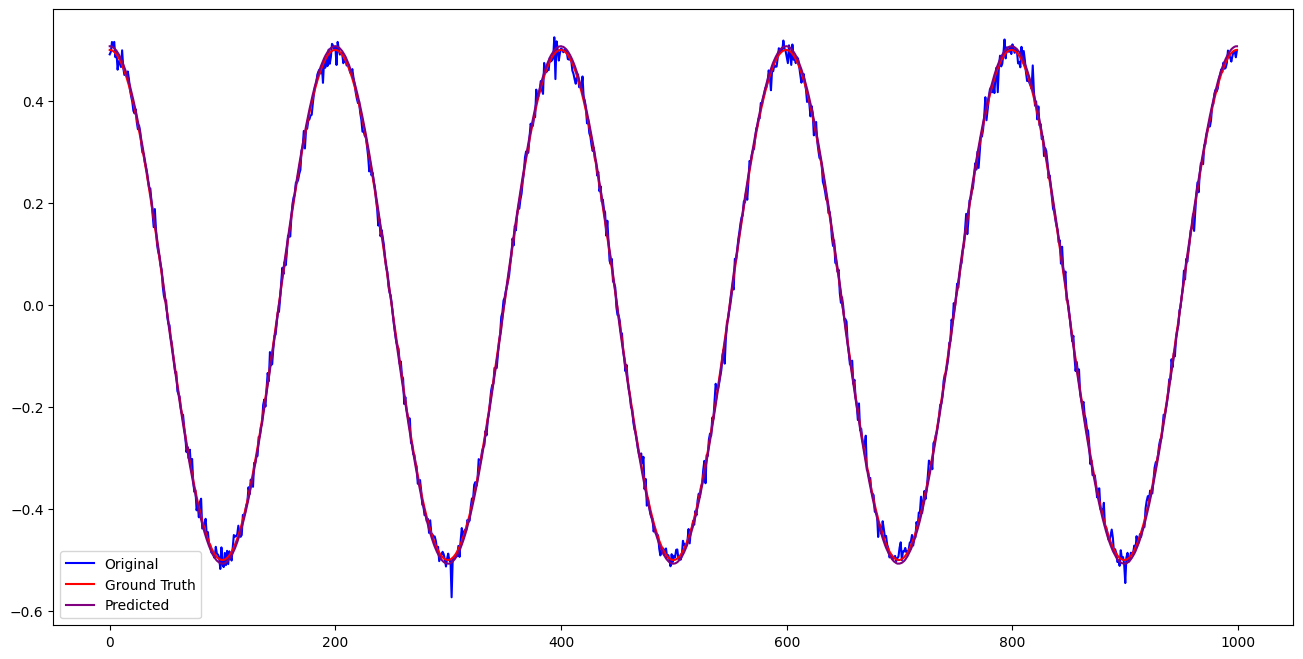

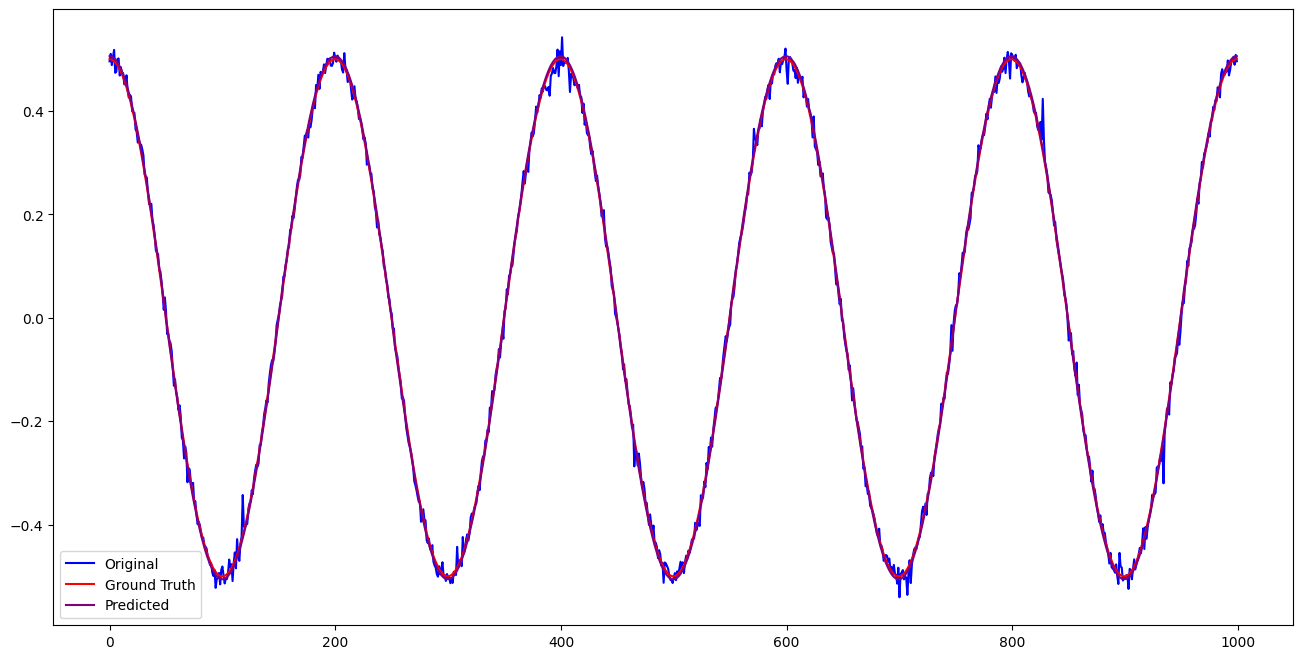

In [11]:
for i in np.random.choice(test_dataset.shape[0], size=5):
    x, y = test_dataset[i]
    
    z = model(x.unsqueeze(dim=1)).detach().numpy().squeeze()
    x = x.squeeze()

    plt.figure(figsize=(16,8))
    plt.plot(x, color='blue', label='Original')
    plt.plot(y, color='red', label='Ground Truth')
    plt.plot(z, color='purple', label='Predicted')
    plt.legend()
    plt.show()